In [1]:
# %matplotlib widget

In [2]:
import numpy as np
import torch
import os
import glob

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
PROBE_DIR = '/home/ajay/sharedajay/clip/nerf/nerf-pytorch/logs/probe/'

# Load CLIP embeddings

In [5]:
!ls -1 /home/ajay/sharedajay/clip/nerf/nerf-pytorch/logs/probe/

emb_blender_paper_chair_clip_vit.pth
emb_blender_paper_drums_clip_vit.pth
emb_blender_paper_ficus_clip_vit.pth
emb_blender_paper_hotdog_clip_vit.pth
emb_blender_paper_lego_clip_vit.pth
emb_blender_paper_materials_clip_vit.pth
emb_blender_paper_mic_clip_vit.pth
emb_blender_paper_ship_clip_vit.pth


In [6]:
embedding_paths = {
    "chair": "emb_blender_paper_chair_clip_vit.pth",
    "drums": "emb_blender_paper_drums_clip_vit.pth",
    "ficus": "emb_blender_paper_ficus_clip_vit.pth",
    "hotdog": "emb_blender_paper_hotdog_clip_vit.pth",
    "lego": "emb_blender_paper_lego_clip_vit.pth",
    "materials": "emb_blender_paper_materials_clip_vit.pth",
    "mic": "emb_blender_paper_mic_clip_vit.pth",
    "ship": "emb_blender_paper_ship_clip_vit.pth",
}

In [7]:
embedding_paths = {
    name: os.path.join(PROBE_DIR, path) for name, path in embedding_paths.items()
}

In [8]:
scenes = {
    name: torch.load(path) for name, path in embedding_paths.items()
}

In [9]:
def pairwise_cosine_similarity(features):
    assert features.ndim == 2  # [B, D]
    norm = torch.norm(features, dim=1)
    features_normalized = features / norm.unsqueeze(1)
    similarity = features_normalized.mm(features_normalized.transpose(0, 1))
    return similarity

In [10]:
def paired_cosine_similarity(features1, features2):
    assert features1.ndim == 2  # [B, D]
    assert features2.ndim == 2  # [B, D]

    norm1 = torch.norm(features1, dim=1)
    features_normalized1 = features1 / norm1.unsqueeze(1)
    
    norm2 = torch.norm(features2, dim=1)
    features_normalized2 = features2 / norm2.unsqueeze(1)

    similarity = features_normalized1.mm(features_normalized2.transpose(0, 1))
    return similarity

In [11]:
def compare_scenes(sd1, sd2):
    embedding1 = torch.from_numpy(sd1['embedding']).float()
    embedding2 = torch.from_numpy(sd2['embedding']).float()
    similarity = paired_cosine_similarity(embedding1, embedding2)
    
    xyz1 = torch.from_numpy(sd1['poses'][:, :-1, 3]).float()
    xyz2 = torch.from_numpy(sd2['poses'][:, :-1, 3]).float()
    diffs = xyz1.unsqueeze(0) - xyz2.unsqueeze(1)
    pose_distances = torch.sqrt((diffs ** 2).sum(dim=-1))

    return similarity, pose_distances

In [12]:
# def make_histogram_plot(axsimilarity, pose_distances, cmap = 'Greens', bins = 30, ylim = [0, 1]):
#     fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6, 3))
#     axes[0].hist2d(x=pose_distances.flatten().cpu().numpy(),
#                    y=similarity.flatten().cpu().numpy(),
#                    cmap=cmap, bins=bins, range=[[0, 8], ylim])
#     axes[0].set_ylabel('Cosine similarity of\nCLIP ViT embeddings')
#     axes[0].set_xlabel('Euclidean distance\nbetween camera origins')

#     axes[1].hist2d(x=pose_similiarty.flatten().cpu().numpy(),
#                    y=similarity.flatten().cpu().numpy(),
#                    cmap=cmap, bins=bins, range=[[-1, 1], ylim])
#     # axes[1].set_ylabel('Cosine similarity of CLIP ViT embeddings')
#     axes[1].set_xlabel('Cosine similarity\nof camera origins')

#     axes[1].set_ylim(ylim)
#     axes[1].set_xlim([-1, 1])

#     plt.tight_layout()
#     os.makedirs("files/", exist_ok=True)
#     plt.savefig("files/representation_similarity_clip_vit.pdf")

#     # plt.title('Camera position versus representation similarity')

In [13]:
scenes["mic"]['poses'].shape

(138, 4, 4)

In [14]:
scene_list = sorted(scenes.keys())
sims = []
for scene1 in scene_list:
    sims.append([compare_scenes(scenes[scene1], scenes[scene2]) for scene2 in scene_list])

In [15]:
diag_similarity = []
for i in range(8):
    similarity, _ = sims[i][i]
    diag_similarity.append(similarity)
diag_similarity = torch.stack(diag_similarity).flatten().numpy()

In [16]:
off_diag_similarity = []
for i in range(8):
    for j in range(i):
        similarity, _ = sims[i][j]
        off_diag_similarity.append(similarity)
off_diag_similarity = torch.stack(off_diag_similarity).flatten().numpy()

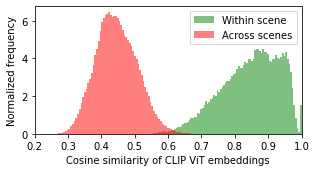

In [17]:
fig, axes = plt.subplots(1, 1, sharey=True, figsize=(4.5, 2.5))
axes.hist(diag_similarity, density=True, bins=100, color="green", alpha=0.5, label="Within scene")
axes.hist(off_diag_similarity, density=True, bins=100, color="red", alpha=0.5, label="Across scenes")
# axes[0].set_title("Within a scene")
axes.set_ylabel("Normalized frequency")
axes.set_xlabel("Cosine similarity of CLIP ViT embeddings")
axes.set_xlim([0.2, 1])
axes.legend()
plt.tight_layout()
plt.savefig("files/cosine_sim_frequency.pdf")
plt.show()

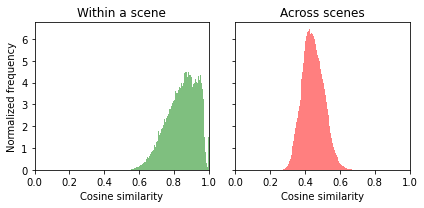

In [18]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6, 3))
axes[0].hist(diag_similarity, density=True, bins=100, color="green", alpha=0.5)
axes[0].set_title("Within a scene")
axes[0].set_ylabel("Normalized frequency")
axes[0].set_xlabel("Cosine similarity")
axes[0].set_xlim([0, 1])

axes[1].set_title("Across scenes")
axes[1].hist(off_diag_similarity, density=True, bins=100, color="red", alpha=0.5)
axes[1].set_xlabel("Cosine similarity")
axes[1].set_xlim([0, 1])
plt.tight_layout()
plt.savefig("files/cosine_sim_frequency_diff.pdf")
plt.show()

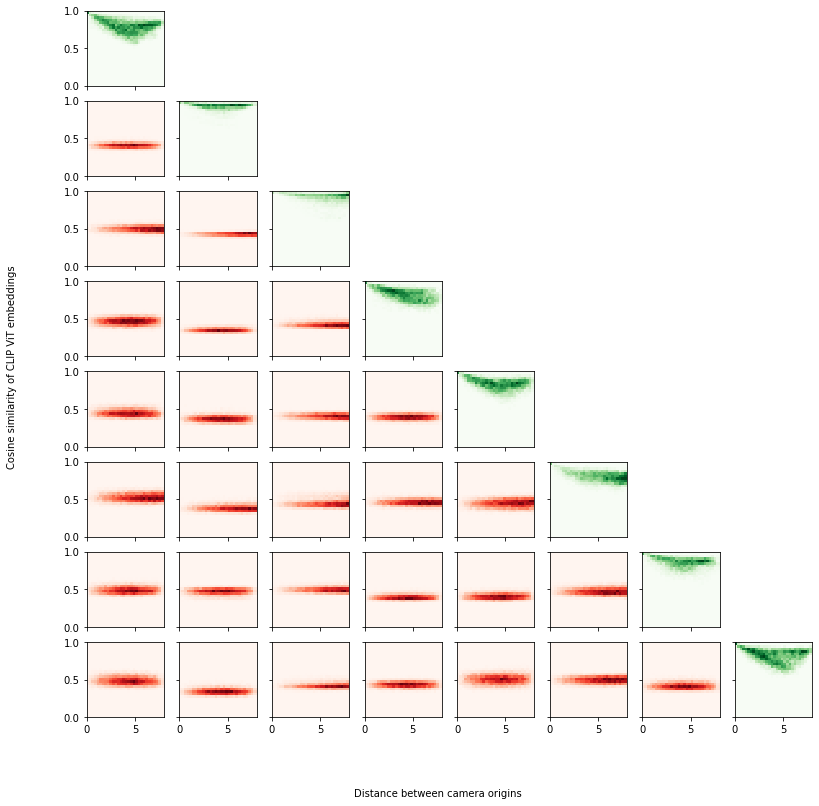

In [19]:
cmap_diag = 'Greens'
cmap_other = 'Reds'
bins = 30
ylim = [0, 1]

fig, axes = plt.subplots(len(sims), len(sims[0]), sharex=True, sharey=True, figsize=(13, 13))
for i in range(len(sims)):
    for j in range(len(sims[0])):
        if i<j:
            axes[i, j].axis('off')
        else:
            similarity, pose_distances = sims[i][j]
            axes[i, j].hist2d(x=pose_distances.flatten().cpu().numpy(),
                              y=similarity.flatten().cpu().numpy(),
                              cmap=cmap_diag if i == j else cmap_other, bins=bins, range=[[0, 8], ylim])
#             if j == 0:
#                 axes[i, j].set_ylabel('Cosine similarity of\nCLIP ViT embeddings')
#             if i == len(sims) - 1:
#                 axes[i, j].set_xlabel('Euclidean distance\nbetween camera origins')
#             axes[i, j].set_title(f"{scene_list[i]} vs {scene_list[j]}")

fig.text(0.5, 0.04, 'Distance between camera origins', ha='center')
fig.text(0.04, 0.5, 'Cosine similarity of CLIP ViT embeddings', va='center', rotation='vertical')

# axes[1].hist2d(x=pose_similiarty.flatten().cpu().numpy(),
#                y=similarity.flatten().cpu().numpy(),
#                cmap=cmap, bins=bins, range=[[-1, 1], ylim])
# axes[1].set_ylabel('Cosine similarity of CLIP ViT embeddings')
# axes[1].set_xlabel('Cosine similarity\nof camera origins')

# axes[1].set_ylim(ylim)
# axes[1].set_xlim([-1, 1])

# plt.tight_layout()
os.makedirs("files/", exist_ok=True)
plt.savefig("files/representation_similarity_clip_vit_triangle_big.pdf")

# plt.title('Camera position versus representation similarity')

# Big grid

In [20]:
# font = {'weight' : 'bold',
#         'size'   : 16}

# matplotlib.rc('font', **font)

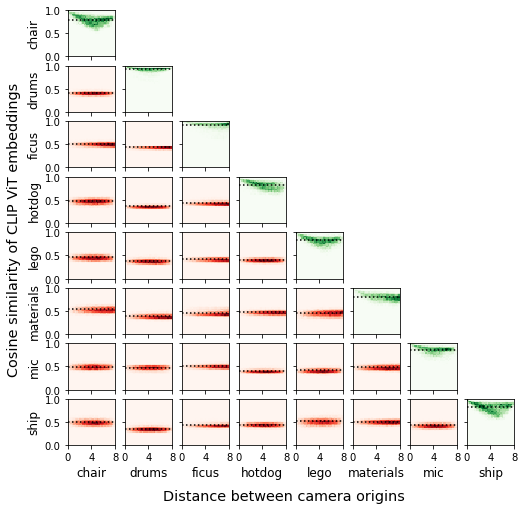

In [47]:
cmap_diag = 'Greens'
cmap_other = 'Reds'
bins = 32
ylim = [0, 1]

fig, axes = plt.subplots(len(sims), len(sims[0]), sharex=True, sharey=True, figsize=(8, 8))
for i in range(len(sims)):
    for j in range(len(sims[0])):
        if i<j:
            axes[i, j].axis('off')
        else:
            similarity, pose_distances = sims[i][j]
            axes[i, j].hlines(similarity.mean().item(), xmin=0, xmax=8, linestyles='dotted', color='black')
            axes[i, j].hist2d(x=pose_distances.flatten().cpu().numpy(),
                              y=similarity.flatten().cpu().numpy(),
                              cmap=cmap_diag if i == j else cmap_other, bins=bins, range=[[0, 8], ylim])
            if j == 0:
                axes[i, j].set_ylabel(f'{scene_list[i]}', fontsize='large')
            if i == len(sims) - 1:
                axes[i, j].set_xlabel(f'{scene_list[j]}', fontsize='large')
            axes[i, j].set_xticks([0, 4, 8])
#             axes[i, j].set_title(f"{scene_list[i]} vs {scene_list[j]}")

fig.text(0.5, 0.03, 'Distance between camera origins', ha='center', fontsize='x-large')
fig.text(0.02, 0.5, 'Cosine similarity of CLIP ViT embeddings', va='center', rotation='vertical', fontsize='x-large')

# axes[1].hist2d(x=pose_similiarty.flatten().cpu().numpy(),
#                y=similarity.flatten().cpu().numpy(),
#                cmap=cmap, bins=bins, range=[[-1, 1], ylim])
# axes[1].set_ylabel('Cosine similarity of CLIP ViT embeddings')
# axes[1].set_xlabel('Cosine similarity\nof camera origins')

# axes[1].set_ylim(ylim)
# axes[1].set_xlim([-1, 1])

# plt.tight_layout()
os.makedirs("files/", exist_ok=True)
plt.savefig("files/representation_similarity_clip_vit_triangle_big.pdf")

# plt.title('Camera position versus representation similarity')

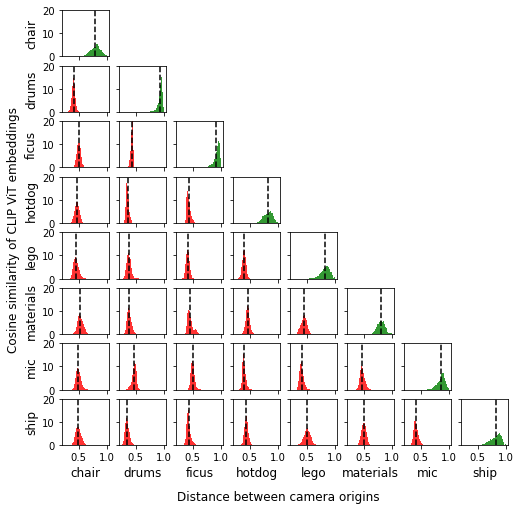

In [42]:
cmap_diag = 'Greens'
cmap_other = 'Reds'
bins = 32
ylim = [0, 1]

fig, axes = plt.subplots(len(sims), len(sims[0]), sharex=True, sharey=True, figsize=(8, 8))
for i in range(len(sims)):
    for j in range(len(sims[0])):
        if i<j:
            axes[i, j].axis('off')
        else:
            similarity, pose_distances = sims[i][j]
            axes[i, j].vlines(similarity.mean().item(), ymin=ylim[0], ymax=40, linestyles='dashed', color='black')
            axes[i, j].hist(similarity.flatten().cpu().numpy(),
                            bins=bins, color='red' if i != j else 'green', alpha=0.8,
                            density=True)
#             axes[i, j].hist2d(x=pose_distances.flatten().cpu().numpy(),
#                               y=similarity.flatten().cpu().numpy(),
#                               cmap=cmap_diag if i == j else cmap_other, bins=bins, range=[[0, 8], ylim])
            if j == 0:
                axes[i, j].set_ylabel(f'{scene_list[i]}', fontsize='large')
            if i == len(sims) - 1:
                axes[i, j].set_xlabel(f'{scene_list[j]}', fontsize='large')
            axes[i, j].set_ylim([0, 20])
#             axes[i, j].set_xticks([0, 4, 8])
#             axes[i, j].set_title(f"{scene_list[i]} vs {scene_list[j]}")

fig.text(0.5, 0.03, 'Distance between camera origins', ha='center', fontsize='large')
fig.text(0.03, 0.5, 'Cosine similarity of CLIP ViT embeddings', va='center', rotation='vertical', fontsize='large')

# plt.tight_layout()
os.makedirs("files/", exist_ok=True)
plt.savefig("files/representation_similarity_clip_vit_triangle_big_1d.pdf")

# plt.title('Camera position versus representation similarity')

# Other

In [24]:
cmap = 'Greens'
bins = 30
ylim = [0, 1]

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6, 3))
axes[0].hist2d(x=pose_distances.flatten().cpu().numpy(),
               y=similarity.flatten().cpu().numpy(),
               cmap=cmap, bins=bins, range=[[0, 8], ylim])
axes[0].set_ylabel('Cosine similarity of\nCLIP ViT embeddings')
axes[0].set_xlabel('Euclidean distance\nbetween camera origins')

# axes[1].hist2d(x=pose_similiarty.flatten().cpu().numpy(),
#                y=similarity.flatten().cpu().numpy(),
#                cmap=cmap, bins=bins, range=[[-1, 1], ylim])
# axes[1].set_ylabel('Cosine similarity of CLIP ViT embeddings')
# axes[1].set_xlabel('Cosine similarity\nof camera origins')

# axes[1].set_ylim(ylim)
# axes[1].set_xlim([-1, 1])

plt.tight_layout()
os.makedirs("files/", exist_ok=True)
plt.savefig("files/representation_similarity_clip_vit.pdf")

# plt.title('Camera position versus representation similarity')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [44]:
similarity, pose_distances = compare_scenes(scenes["lego"], scenes["drums"])
plt.figure()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Make histograms

In [22]:
cmap = 'Greens'
bins = 30
ylim = [0, 1]

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6, 3))
axes[0].hist2d(x=pose_distances.flatten().cpu().numpy(),
               y=similarity.flatten().cpu().numpy(),
               cmap=cmap, bins=bins, range=[[0, 8], ylim])
axes[0].set_ylabel('Cosine similarity of\nCLIP ViT embeddings')
axes[0].set_xlabel('Euclidean distance\nbetween camera origins')

axes[1].hist2d(x=pose_similiarty.flatten().cpu().numpy(),
               y=similarity.flatten().cpu().numpy(),
               cmap=cmap, bins=bins, range=[[-1, 1], ylim])
# axes[1].set_ylabel('Cosine similarity of CLIP ViT embeddings')
axes[1].set_xlabel('Cosine similarity\nof camera origins')

axes[1].set_ylim(ylim)
axes[1].set_xlim([-1, 1])

plt.tight_layout()
os.makedirs("files/", exist_ok=True)
plt.savefig("files/representation_similarity_clip_vit.pdf")

# plt.title('Camera position versus representation similarity')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Pose similiarity (ground truth)

In [9]:
scene_data['poses'][0]

array([[-9.9990219e-01,  4.1922452e-03, -1.3345719e-02, -5.3798322e-02],
       [-1.3988681e-02, -2.9965907e-01,  9.5394367e-01,  3.8454704e+00],
       [-4.6566129e-10,  9.5403719e-01,  2.9968831e-01,  1.2080823e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)

In [10]:
poses = torch.from_numpy(scene_data['poses']).float()

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(poses[:, 0, -1], poses[:, 1, -1], poses[:, 2, -1])
plt.title('Camera origins')
fig.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
xyz = poses[:, :-1, 3]
diffs = xyz.unsqueeze(0) - xyz.unsqueeze(1)
pose_distances = torch.sqrt((diffs ** 2).sum(dim=-1))

In [13]:
thetas = torch.atan2(xyz[:, 1], xyz[:, 0])

In [14]:
pose_similiarty = pairwise_cosine_similarity(xyz)

In [15]:
plt.figure()
plt.imshow(pose_similiarty)
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
# pose_similarity = pairwise_cosine_similarity(poses[:, :, 3].flatten(1))
plt.figure()
plt.imshow(pose_distances)
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [17]:
colors = torch.cat([thetas for _ in range(len(thetas))])

plt.figure()
plt.scatter(pose_distances.flatten(), similarity.flatten(), c=colors)
plt.ylabel('Cosine similiarity of CLIP ViT embeddings')
plt.xlabel('Euclidean distance between cameras')
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'os' is not defined

In [46]:
plt.figure()
plt.hist2d(x=pose_distances.flatten().cpu().numpy(), y=similarity.flatten().cpu().numpy())
plt.ylabel('Cosine similarity of CLIP ViT embeddings')
plt.xlabel('Euclidean distance between camera origins')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Euclidean distance between camera origins')

In [47]:
colors = torch.cat([thetas for _ in range(len(thetas))])

plt.figure()
# plt.scatter(pose_similiarty.flatten(), similarity.flatten(), c=colors)
plt.hist2d(x=pose_similiarty.flatten().cpu().numpy(), y=similarity.flatten().cpu().numpy())
plt.ylabel('Cosine similarity of CLIP ViT embeddings')
plt.xlabel('Cosine similarity of camera origins')
# plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Cosine similarity of camera origins')

In [18]:
colors = torch.cat([thetas for _ in range(len(thetas))])

plt.figure()
plt.scatter(torch.acos(pose_similiarty).flatten(), similarity.flatten(), c=colors)
plt.ylabel('Cosine similarity of CLIP ViT embeddings')
plt.xlabel('Angle between cameras')
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
colors = torch.cat([thetas for _ in range(len(thetas))])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
idx = np.random.choice(len(thetas) ** 2, size=1000, replace=False)
ax.scatter(torch.acos(pose_similiarty).flatten()[idx], pose_distances.flatten()[idx], similarity.flatten()[idx], c=colors[idx])
ax.set_zlabel('Cosine similiarity of CLIP ViT embeddings')
ax.set_xlabel('Angle between cameras')
ax.set_ylabel('Euclidean distance between cameras')
# plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Euclidean distance between cameras')

In [29]:
plt.figure()
_ = plt.hist(pose_distances.flatten().numpy(), bins=100)
plt.title('Distribution of pairwise euclidean distance between camera origins')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Distribution of pairwise euclidean distance between camera origins')

In [33]:
plt.figure()
_ = plt.hist(similarity.numpy().flatten(), bins=100)
plt.title('Distribution of pairwise cosine similarity\nbetween training image ViT embeddings')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Distribution of pairwise cosine similarity\nbetween training image ViT embeddings')

In [22]:
plt.figure()
_ = plt.hist(-similarity.numpy().flatten(), bins=100, cumulative=True, density=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Dimensionality reduction

In [23]:
def dim_reduction(X, color='blue', n_neighbors=10, n_components=2, mds_max_iter=100):
    from collections import OrderedDict
    from functools import partial
    from time import time

    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.ticker import NullFormatter

    from sklearn import manifold, datasets

    # Next line to silence pyflakes. This import is needed.
    Axes3D

    n_points = len(X)

    # Create figure
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle("Manifold Learning with %i points, %i neighbors"
                 % (1000, n_neighbors), fontsize=14)

    # Add 3d scatter plot
    ax = fig.add_subplot(251, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)

    # Set-up manifold methods
    LLE = partial(manifold.LocallyLinearEmbedding,
                  n_neighbors, n_components, eigen_solver='auto')

    methods = OrderedDict()
    methods['LLE'] = LLE(method='standard')
    methods['LTSA'] = LLE(method='ltsa')
    methods['Hessian LLE'] = LLE(method='hessian')
    methods['Modified LLE'] = LLE(method='modified')
    methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
    methods['MDS'] = manifold.MDS(n_components, max_iter=mds_max_iter, n_init=1)
    methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                               n_neighbors=n_neighbors)
    methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                     random_state=0)

    # Plot results
    for i, (label, method) in enumerate(methods.items()):
        t0 = time()
        Y = method.fit_transform(X)
        t1 = time()
        print("%s: %.2g sec" % (label, t1 - t0))
        ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
        ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
        ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')

    plt.show()

In [24]:
# Dimensionality reduction of camera origin. Colored by theta (rotation around vertical axis)
dim_reduction(xyz, thetas, n_neighbors=10, n_components=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/ajay/miniconda3/envs/clip/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=10, n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


LLE: 0.15 sec
LTSA: 0.056 sec
Hessian LLE: 0.064 sec
Modified LLE: 0.057 sec
Isomap: 0.038 sec
MDS: 0.028 sec
SE: 0.01 sec
t-SNE: 0.59 sec


In [25]:
# Dimensionality reduction of c2w matrices. Colored by theta (rotation around vertical axis)
dim_reduction(poses.flatten(1), thetas, n_neighbors=10, n_components=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

LLE: 0.045 sec
LTSA: 0.06 sec


/home/ajay/miniconda3/envs/clip/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=10, n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Hessian LLE: 0.079 sec
Modified LLE: 0.065 sec
Isomap: 0.053 sec
MDS: 0.024 sec
SE: 0.012 sec
t-SNE: 0.51 sec


In [26]:
# Dimensionality reduction of CLIP ViT embeddings. Colored by theta (rotation around vertical axis)
dim_reduction(embedding, thetas, n_neighbors=10, n_components=2, mds_max_iter=1000)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

LLE: 0.043 sec
LTSA: 0.067 sec


/home/ajay/miniconda3/envs/clip/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=10, n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Hessian LLE: 0.078 sec
Modified LLE: 0.068 sec
Isomap: 0.032 sec
MDS: 0.19 sec
SE: 0.011 sec
t-SNE: 0.77 sec


In [27]:
embedding.shape

torch.Size([138, 512])